# Testing `Whirl2d` on Navier-Stokes solution with a body 

In [160]:
include(joinpath(Pkg.dir("whirl2d"), "src/Whirl2d.jl"))
import Whirl2d
import Whirl2d:@get
using PyPlot
@get Whirl2d (Systems, Grids, DualPatch, Bodies, TimeMarching, NavierStokes);

### Create a body

In [24]:
Npts = 100
len = 1
xcent = [0.0,0.0]
ang = 3π/4
b = Bodies.Plate(Npts,len,xcent,ang)

Body: number of points = 100, reference point = (0.0,0.0), rotation matrix = [-0.707107 -0.707107; 0.707107 -0.707107]


### Create a domain with this body in it

In [25]:
xmin = [-1.0,-1.0]
xmax = [3.0,1.0]
dom = Systems.DualDomain(xmin,xmax)
dom = Systems.add_body(dom,b)

Domain: xmin = [-1.0, -1.0], xmax = [3.0, 1.0]
number of bodies = 1
Body: number of points = 100, reference point = (0.0,0.0), rotation matrix = [-0.707107 -0.707107; 0.707107 -0.707107]



#### Add a filling dual grid to this domain
The boundaries of the domain coincide with the boundaries of the dual grid

In [52]:
Δx = 0.02
dom = Systems.add_grid(dom,Δx)

Domain: xmin = [-1.0, -1.0], xmax = [3.0, 1.0]
number of bodies = 1
Body: number of points = 100, reference point = (0.0,0.0), rotation matrix = [-0.707107 -0.707107; 0.707107 -0.707107]

Grid: number of cells = (200,100), Δx = 0.02, xmin = [-1.0, -1.0], xmax = [3.0, 1.0]



### Set the physical and time parameters

In [88]:
Re = 500
physparams = NavierStokes.set_freestream([1.0,0.0])
NavierStokes.set_Re!(physparams,Re)
Δt = min(0.5*Δx,Δx^2*Re)

α = Δt/(Re*Δx^2)
tparams = TimeMarching.TimeParams(Δt,TimeMarching.RK31())

params = (physparams,α)

(Whirl2d.NavierStokes.PhysParams([1.0, 0.0], 500.0), 0.049999999999999996)

### Compute the grid and body operators
This fills in the LGF and integrating factor tables, computes the interpolation/regularization operators, computes the Schur complement operators and factorizes them, and defines the operators needed for calling the HERK

In [89]:
@time ops = NavierStokes.set_operators_body!(dom,params);
A⁻¹,B₁ᵀ,B₂!,S⁻¹,S₀⁻¹,r₁,r₂ = ops

  7.494911 seconds (74.12 M allocations: 4.974 GiB, 8.26% gc time)


(Whirl2d.NavierStokes.A⁻¹, Whirl2d.NavierStokes.B₁ᵀ, Whirl2d.NavierStokes.B₂!, Whirl2d.NavierStokes.S⁻¹, Whirl2d.NavierStokes.S₀⁻¹, Whirl2d.NavierStokes.r₁, Whirl2d.NavierStokes.r₂)

### Create an initial solution structure

In [94]:
s = NavierStokes.BodySoln(dom)

Solution: t = 0.0


### Advance the solution

In [95]:
@time for i = 1:1
    s = TimeMarching.ifherk!(s,tparams,A⁻¹,B₁ᵀ,B₂!,S⁻¹,S₀⁻¹,r₁,r₂)
end
s

  0.152634 seconds (1.60 M allocations: 122.227 MiB, 9.08% gc time)


Solution: t = 0.01


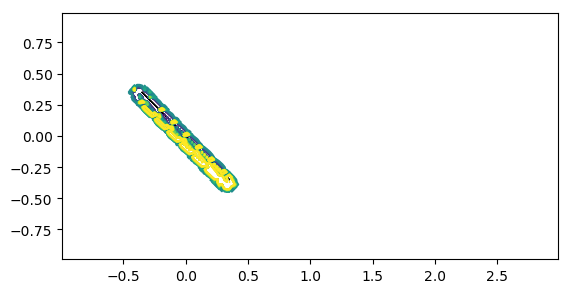

(-0.99, 2.99, -0.99, 0.99)

In [96]:
x = [dom.grid.xmin[1]+Δx*(i-1/2) for i=1:dom.grid.N[1], j=1:dom.grid.N[2]]
y = [dom.grid.xmin[2]+Δx*(j-1/2) for i=1:dom.grid.N[1], j=1:dom.grid.N[2]]

contour(x,y,s.u[dom.grid.cellint[1],dom.grid.cellint[2]]/Δx,linspace(-10,10,30))
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k")
end
axis("scaled")

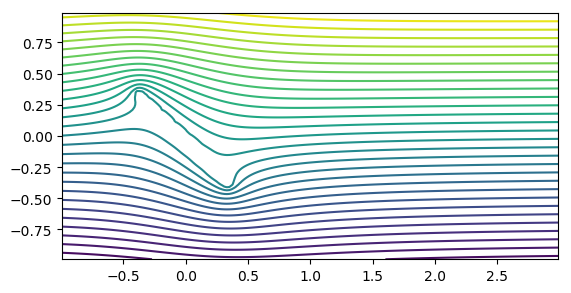

(-0.99, 2.99, -0.99, 0.99)

In [102]:
s.ψ = -Grids.L⁻¹(dom.grid,s.u)
contour(x,y,s.ψ[dom.grid.cellint[1],dom.grid.cellint[2]]*Δx+y,linspace(-1,1,31))
axis("scaled")